In [1]:
from utils.lang_maps import HR_MAP 
from utils.task_vectors import TaskVector
from transformers import WhisperForConditionalGeneration
models_dir = "output_whisper-tiny"
ALL_LANGS = list(set(HR_MAP.keys()).union(set("_".join(v) for v in HR_MAP.values())))
TVs = {}
for lang in ALL_LANGS:
    if lang != "":
        TVs[lang] = TaskVector(
            pretrained_model=WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny"),
            finetuned_model=WhisperForConditionalGeneration.from_pretrained(f"{models_dir}/{lang}/final")
        )


/Users/erafkin/Desktop/School/graduate/2025-2026/mozilla-asr-challenge/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
import pandas as pd
import json
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import torch
model = "results/whisper-tiny-NEW"
rows = []
summary_df = pd.read_csv(f"{model}/summary.csv")
lang_hr_gains = {}
for result in os.listdir(f"{model}/hyperparameters"):
    with open(f"{model}/hyperparameters/" + result, "r") as f:
        hyps = json.load(f)
        f.close()
    if len(hyps) > 0:
        lang_name = result.split(".")[0]
        lang_hr_gains[lang_name] = {}
        best_score = min(hyps.values())
        best_lambda = min(hyps, key=hyps.get)
        score_0 = hyps["0.0"]
        lang_hr_gains[lang_name]["lambda"] = best_lambda
        lang_hr_gains[lang_name]["hr_delta"] = abs(score_0 - best_score)
        language_tv = TVs[lang_name]
        hr_tv = TVs["_".join(HR_MAP[lang_name])]
        cossim = cosine_similarity(language_tv.tv_to_vector().reshape(1, -1), hr_tv.tv_to_vector().reshape(1, -1))[0][0]
        # Calculate the element-wise difference
        difference = [language_tv.vector[k] - hr_tv.vector[k] for k in language_tv.vector.keys()] 
        # Square each element of the difference matrix
        squared_difference = [np.square(d.flatten()) for d in difference]
        # Calculate the mean of all elements in the squared_difference matrix
        mse = np.mean(torch.cat(squared_difference).numpy())
        layer_wise_mse = [np.mean(l.numpy()) for l in squared_difference]
        lang_hr_gains[lang_name]["cosine_sim"] = cossim
        lang_hr_gains[lang_name]["mse"] = mse
        lang_hr_gains[lang_name]["layer_wise_mse"] = layer_wise_mse
        lang_hr_gains[lang_name]["wer"] = best_score



In [67]:
df = pd.DataFrame(lang_hr_gains).T
df

,lambda,hr_delta,cosine_sim,mse,layer_wise_mse,wer
rwm,0.03378863811999887,0.039316,0.101265,0.000289,"[2.205759e-05, 5.8241287e-05, 4.2103584e-05, 2...",0.782622
bew,0.436308948870678,0.107666,0.228761,0.000034,"[2.758683e-06, 3.1120874e-06, 3.865313e-06, 1....",0.748596
koo,0.1558817920436369,0.054721,0.127657,0.00029,"[2.0434016e-05, 4.8198563e-05, 4.1991585e-05, ...",0.857588
hch,0.15515734699049857,0.048941,0.459649,0.000028,"[2.2468603e-06, 3.0037907e-06, 3.6068918e-06, ...",0.8511
ady,0.04022445861816864,0.007309,0.463989,0.00009,"[2.9901541e-05, 8.362203e-05, 6.071063e-05, 3....",0.7991
aln,0.0351300872862339,0.018653,0.517629,0.000024,"[3.038547e-06, 2.560898e-06, 5.358011e-06, 1.5...",0.728949
cgg,0.21093589471308438,0.075202,0.119722,0.000287,"[2.094964e-05, 5.1487237e-05, 4.151314e-05, 2....",0.61029
mmc,0.1588065454594033,0.098074,0.382418,0.000036,"[3.1394256e-06, 6.400636e-06, 5.793643e-06, 3....",0.824684
ush,0.14255016966578468,0.021054,0.73058,0.000059,"[1.1329975e-05, 2.4427542e-05, 2.1341533e-05, ...",0.602577
el-CY,0.11710001205757978,0.025157,0.776042,0.000017,"[4.5665365e-06, 6.2655968e-06, 8.2156785e-06, ...",0.827242


In [68]:
df.drop('layer_wise_mse', axis=1).corr()

,lambda,hr_delta,cosine_sim,mse,wer
lambda,1.000000,0.695350,0.102441,-0.182847,-0.197844
hr_delta,0.695350,1.000000,-0.214252,0.113722,0.146819
cosine_sim,0.102441,-0.214252,1.000000,-0.846192,-0.096647
mse,-0.182847,0.113722,-0.846192,1.000000,0.065700
wer,-0.197844,0.146819,-0.096647,0.065700,1.000000


In [69]:
len(lang_hr_gains["kbd"]["layer_wise_mse"]), len(lang_hr_gains["ukv"]["layer_wise_mse"])


(168, 168)

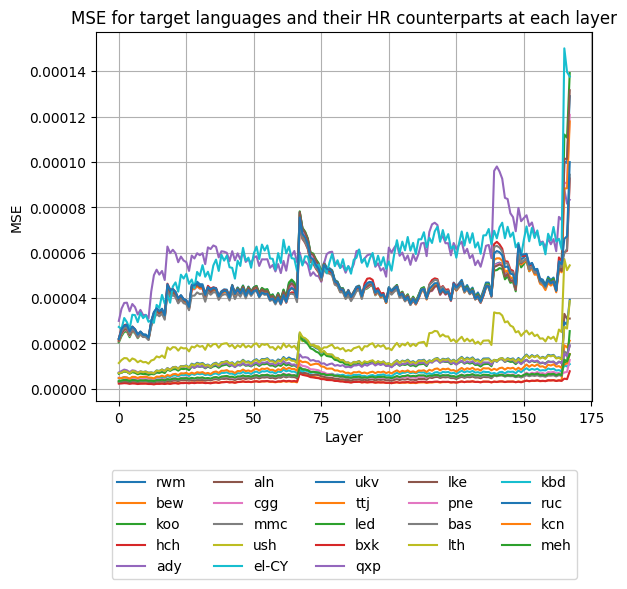

In [70]:
import matplotlib.pyplot as plt
# Plotting all lines at once
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed
mse_graph = [(lang, item["layer_wise_mse"]) for lang, item in lang_hr_gains.items()]
xs = range(len(mse_graph[0][1]))
ys = np.array([smooth(v[1], 0.9) for v in mse_graph]).T
labels = [v[0] for v in mse_graph]

fig, ax = plt.subplots()

ax.plot(xs, ys, label=labels)

# Adding labels and legend (you would need to manually create labels here if desired)
ax.set_xlabel('Layer')
ax.set_ylabel('MSE')
# ax.set_yscale("log")
ax.set_title('MSE for target languages and their HR counterparts at each layer')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=5) 
ax.grid(True)
plt.show()


In [7]:
import pandas as pd
import json
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import torch
model = "results/whisper-tiny-NEW"
rows = []
summary_df = pd.read_csv(f"{model}/summary.csv")
lang_hr_gains = {}
for result in os.listdir(f"{model}/hyperparameters"):
    with open(f"{model}/hyperparameters/" + result, "r") as f:
        hyps = json.load(f)
        f.close()
    if len(hyps) > 0:
        lang_name = result.split(".")[0]
        lang_hr_gains[lang_name] = {}
        best_score = min(hyps.values())
        best_lambda = min(hyps, key=hyps.get)
        score_0 = hyps["0.0"]
        lang_hr_gains[lang_name]["lambda"] = best_lambda
        lang_hr_gains[lang_name]["hr_delta"] = abs(score_0 - best_score)
        language_tv = TVs[lang_name]
        hr_tv = TVs["_".join(HR_MAP[lang_name])]
        # Calculate the element-wise difference
        lr_layerwise, layer_strs = language_tv.tv_to_layer_wise()
        hr_layerwise, _ = hr_tv.tv_to_layer_wise()
        cossim_layerwise = [cosine_similarity(lr_layerwise[i].reshape(1, -1), hr_layerwise[i].reshape(1, -1))[0][0] for i in range(len(lr_layerwise))]
        difference = [np.array(lr_layerwise[i]) - np.array(hr_layerwise[i]) for i in range(len(lr_layerwise))]
        # Square each element of the difference matrix
        squared_difference = [np.square(d) for d in difference]
        # Calculate the mean of all elements in the squared_difference matrix
        layer_wise_mse = [np.mean(l) for l in squared_difference]
        lang_hr_gains[lang_name]["cosine_sim"] = np.mean(cossim_layerwise)
        lang_hr_gains[lang_name]["mse"] = np.mean(layer_wise_mse)
        lang_hr_gains[lang_name]["layer_wise_mse"] = layer_wise_mse
        lang_hr_gains[lang_name]["layer_wise_cossim"] = cossim_layerwise

        lang_hr_gains[lang_name]["wer"] = best_score
df = pd.DataFrame(lang_hr_gains).T


In [8]:
df

,lambda,hr_delta,cosine_sim,mse,layer_wise_mse,layer_wise_cossim,wer
rwm,0.03378863811999887,0.039316,0.070467,0.000102,"[2.2207729e-05, 4.2092604e-05, 0.0, 4.312464e-...","[0.19846615, 0.107089765, 0.0, 0.04930628, 0.0...",0.782622
bew,0.436308948870678,0.107666,0.12196,0.000014,"[2.7601493e-06, 3.863443e-06, 0.0, 3.607795e-0...","[0.07872386, 0.054873012, 0.0, 0.04199028, 0.0...",0.748596
koo,0.1558817920436369,0.054721,0.094309,0.000107,"[2.054922e-05, 4.1978146e-05, 0.0, 4.3921413e-...","[0.31887105, 0.14181195, 0.0, 0.06847166, 0.07...",0.857588
hch,0.15515734699049857,0.048941,0.137282,0.000008,"[2.2500012e-06, 3.6052882e-06, 0.0, 3.47043e-0...","[0.15186554, 0.05428341, 0.0, 0.03129821, 0.04...",0.8511
ady,0.04022445861816864,0.007309,0.207729,0.000066,"[3.0124449e-05, 6.0691822e-05, 0.0, 6.153724e-...","[0.3063839, 0.18646827, 0.0, 0.0886859, 0.0752...",0.7991
aln,0.0351300872862339,0.018653,0.198167,0.000018,"[3.036565e-06, 5.3546696e-06, 0.0, 5.7583375e-...","[0.1481533, 0.07379021, 0.0, 0.03188505, 0.054...",0.728949
cgg,0.21093589471308438,0.075202,0.094345,0.000099,"[2.1076352e-05, 4.1500618e-05, 0.0, 4.2787375e...","[0.2801808, 0.1364411, 0.0, 0.07163512, 0.0858...",0.61029
mmc,0.1588065454594033,0.098074,0.064317,0.000014,"[3.1529576e-06, 5.791615e-06, 0.0, 5.60353e-06...","[0.08649285, 0.022373127, 0.0, 0.02700325, 0.0...",0.824684
ush,0.14255016966578468,0.021054,0.238551,0.000038,"[1.13843225e-05, 2.1334003e-05, 0.0, 2.1786347...","[0.19641027, 0.10250783, 0.0, 0.042357422, 0.0...",0.602577
el-CY,0.11710001205757978,0.025157,0.250326,0.000011,"[4.5735865e-06, 8.211414e-06, 0.0, 8.808081e-0...","[0.14941993, 0.0969207, 0.0, 0.029796766, 0.05...",0.827242


In [9]:
df_2 = df
new_cols_df = df_2['layer_wise_mse'].apply(pd.Series).round(2)

new_cols_df.columns = [f'mse_{i+1}' for i in range(new_cols_df.shape[1])]
df_2 = pd.concat([df_2.drop('layer_wise_mse', axis=1), new_cols_df], axis=1)

new_cols_df = df_2['layer_wise_cossim'].apply(pd.Series).round(2)

# Optionally, rename the new columns for clarity
new_cols_df.columns = [f'cossim_{i+1}' for i in range(new_cols_df.shape[1])]
df_2 = pd.concat([df_2.drop('layer_wise_cossim', axis=1), new_cols_df], axis=1)
df_2.corr().hr_delta

lambda        0.695350
hr_delta      1.000000
cosine_sim   -0.256578
mse          -0.002582
wer           0.146819
mse_1              NaN
mse_2              NaN
mse_3              NaN
mse_4              NaN
mse_5              NaN
mse_6              NaN
mse_7              NaN
mse_8              NaN
mse_9              NaN
mse_10             NaN
mse_11             NaN
mse_12             NaN
mse_13             NaN
mse_14             NaN
mse_15             NaN
mse_16             NaN
cossim_1     -0.183754
cossim_2     -0.268164
cossim_3           NaN
cossim_4     -0.111478
cossim_5      0.105004
cossim_6      0.257041
cossim_7      0.226118
cossim_8     -0.120610
cossim_9     -0.228480
cossim_10    -0.208903
cossim_11    -0.024762
cossim_12     0.163293
cossim_13     0.143033
cossim_14     0.130998
cossim_15    -0.287974
cossim_16    -0.228480
Name: hr_delta, dtype: float64

In [10]:
df_2

,lambda,hr_delta,cosine_sim,mse,wer,mse_1,mse_2,mse_3,mse_4,mse_5,...,cossim_7,cossim_8,cossim_9,cossim_10,cossim_11,cossim_12,cossim_13,cossim_14,cossim_15,cossim_16
rwm,0.03378863811999887,0.039316,0.070467,0.000102,0.782622,0.0,0.0,0.0,0.0,0.0,...,0.03,0.38,0.10,0.01,0.05,0.04,0.04,0.05,-0.13,0.10
bew,0.436308948870678,0.107666,0.12196,0.000014,0.748596,0.0,0.0,0.0,0.0,0.0,...,0.06,0.27,0.23,0.01,0.08,0.07,0.06,0.13,0.48,0.23
koo,0.1558817920436369,0.054721,0.094309,0.000107,0.857588,0.0,0.0,0.0,0.0,0.0,...,0.04,0.42,0.13,0.02,0.06,0.05,0.05,0.06,-0.12,0.13
hch,0.15515734699049857,0.048941,0.137282,0.000008,0.8511,0.0,0.0,0.0,0.0,0.0,...,0.03,0.02,0.48,0.01,0.06,0.05,0.05,0.10,0.61,0.48
ady,0.04022445861816864,0.007309,0.207729,0.000066,0.7991,0.0,0.0,0.0,0.0,0.0,...,0.03,0.44,0.52,0.04,0.07,0.05,0.06,0.05,0.85,0.52
aln,0.0351300872862339,0.018653,0.198167,0.000018,0.728949,0.0,0.0,0.0,0.0,0.0,...,0.05,0.50,0.54,0.01,0.07,0.07,0.06,0.12,0.85,0.54
cgg,0.21093589471308438,0.075202,0.094345,0.000099,0.61029,0.0,0.0,0.0,0.0,0.0,...,0.06,0.36,0.12,0.01,0.07,0.06,0.07,0.09,-0.11,0.12
mmc,0.1588065454594033,0.098074,0.064317,0.000014,0.824684,0.0,0.0,0.0,0.0,0.0,...,0.02,-0.09,0.40,-0.00,0.02,0.02,0.03,0.04,-0.03,0.40
ush,0.14255016966578468,0.021054,0.238551,0.000038,0.602577,0.0,0.0,0.0,0.0,0.0,...,0.05,0.53,0.77,0.02,0.09,0.06,0.07,0.12,0.90,0.77
el-CY,0.11710001205757978,0.025157,0.250326,0.000011,0.827242,0.0,0.0,0.0,0.0,0.0,...,0.06,0.60,0.81,0.00,0.08,0.06,0.07,0.16,0.96,0.81


In [11]:

lang_hr_gains

{'rwm': {'lambda': '0.03378863811999887',
  'hr_delta': 0.03931559105014415,
  'cosine_sim': 0.07046723,
  'mse': 0.00010239992,
  'layer_wise_mse': [2.2207729e-05,
   4.2092604e-05,
   0.0,
   4.312464e-05,
   4.8839695e-05,
   6.172678e-05,
   6.742027e-05,
   2.260356e-05,
   0.0003942457,
   6.178165e-06,
   5.0230126e-05,
   5.4673037e-05,
   5.869408e-05,
   6.45272e-05,
   0.0003075895,
   0.0003942457],
  'layer_wise_cossim': [0.19846615,
   0.107089765,
   0.0,
   0.04930628,
   0.056782864,
   0.040124908,
   0.0318143,
   0.37848932,
   0.10448258,
   0.009689072,
   0.049945742,
   0.043659993,
   0.037403397,
   0.04890643,
   -0.13316768,
   0.10448258],
  'wer': 0.782621911806496},
 'bew': {'lambda': '0.436308948870678',
  'hr_delta': 0.10766559917979113,
  'cosine_sim': 0.12196047,
  'mse': 1.4049274e-05,
  'layer_wise_mse': [2.7601493e-06,
   3.863443e-06,
   0.0,
   3.607795e-06,
   3.96159e-06,
   4.923519e-06,
   5.4512366e-06,
   1.9202723e-06,
   4.801744e-05,
   

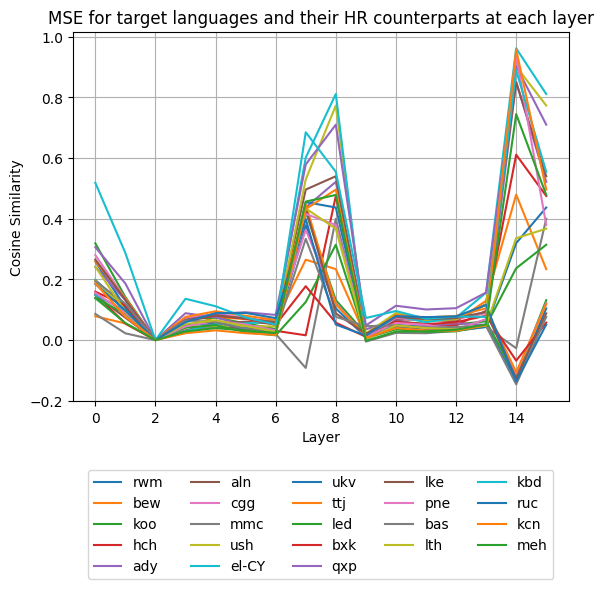

In [15]:
import matplotlib.pyplot as plt
# Plotting all lines at once
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed
mse_graph = [(lang, item["layer_wise_cossim"]) for lang, item in lang_hr_gains.items()]
xs = range(len(mse_graph[0][1]))
ys = np.array([smooth(v[1], 0.9) for v in mse_graph]).T
ys = np.array([v[1]for v in mse_graph]).T

labels = [v[0] for v in mse_graph]

fig, ax = plt.subplots()

ax.plot(xs, ys, label=labels)

# Adding labels and legend (you would need to manually create labels here if desired)
ax.set_xlabel('Layer')
ax.set_ylabel('Cosine Similarity')
# ax.set_yscale("log")
ax.set_title('MSE for target languages and their HR counterparts at each layer')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=5) 
ax.grid(True)
plt.show()
